# Introducción

Un árbol de comportamiento es un modelo matemático que se utiliza para definir qué acciones realizar dependiendo de la situación en la que se encuentre nuestro robot. Se define a través de un grafo de nodos (no confundir con los nodos de ROS), cada uno de los cuales ejecutará unas acciones concretas. Estos árboles de comportamiento los describimos utilizando un fichero xml.

Existen dos tipos de nodos:

- **nodos de control de flujo**: especifican cómo se ejecutarán los nodos de la rama que cuelga de ellos

- **nodos de acción**: ejecutan acciones

- **nodos de condición**: chequean si se cumple una determinada condición

- **nodos decoradores** (decorators): configuran algún parámetro

Todos los nodos poseen cuatro posibles estados de salida: **idle, running,  success y failure**.


En primer lugar vamos a estudia qué tipos de nodos de control de flujo podemos encontrar.

# Nodos de control de flujo

Existen diferentes formas de dirigir el flujo de la aplicación. Vamos a ver algunas de ellas. Para ello partimos del esquema básico en el que existe un nodo de control (pintado en verde) del que cuelgan varios nodos de acción (en gris). El nodo de control es el encargado de decidir en qué orden y bajo qué condiciones se van a ejecutar los nodos de acción.

- **Sequence**: comienza ejecutándose la primera acción (la situada a la izquierda del grafo). Si la acción termina con un estado failure, la salida del nodo de control será failure y no pasará a ejecutar el segundo nodo de acción. Si por el contrario la salida del primer nodo es *success* comenzará a ejecutarse el segundo nodo.


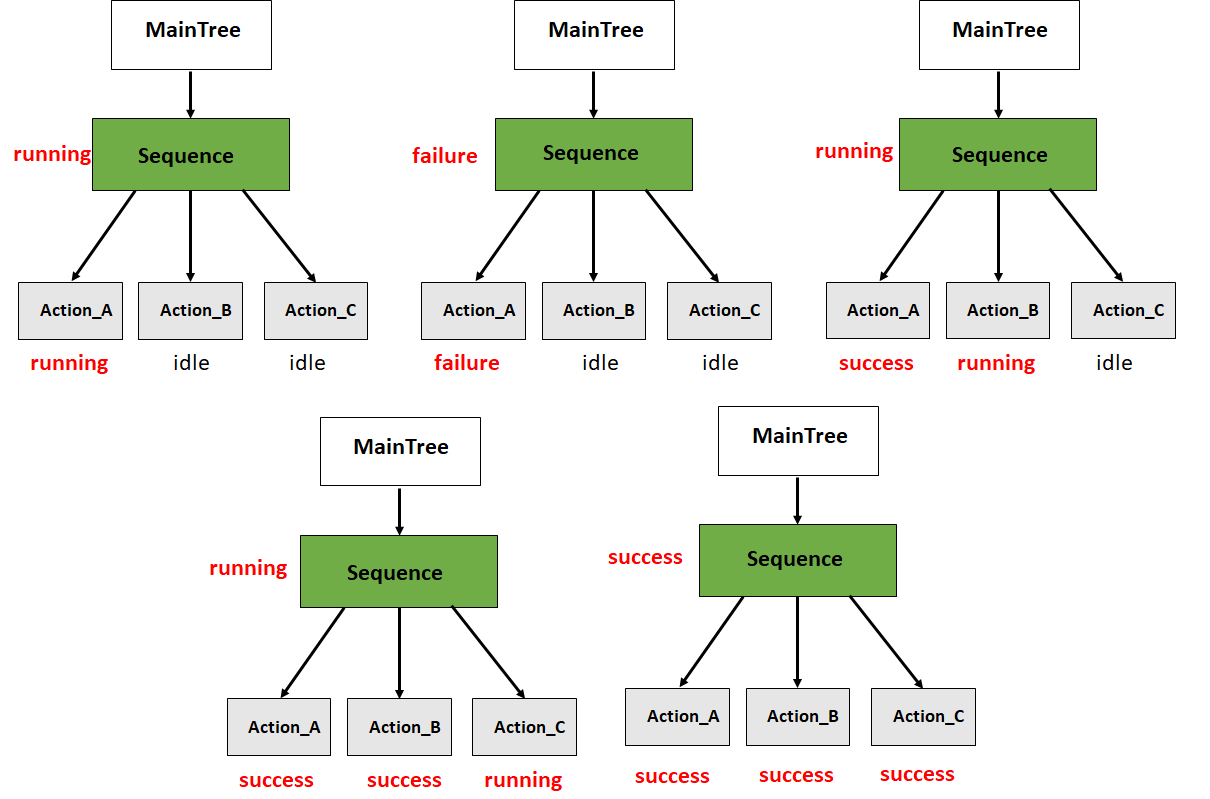

La sintaxis para describir este grafo es:

In [ ]:
<root main_tree_to_execute="MainTree">
    <BehaviorTree ID="MainTree">
        <Sequence name="Sequence">
            <Action_A/>
            <Action_B/>
            <Action_C/>
        </Sequence>
    </BehaviorTree>
</root>

- **Fallback**: va ejecutando una acción detrás de otra siempre que el resultado de ellas sea failure. Cuando una de ellas devuelve success la salida del nodo de control será success y no siguen ejecutándose el resto de los nodos.

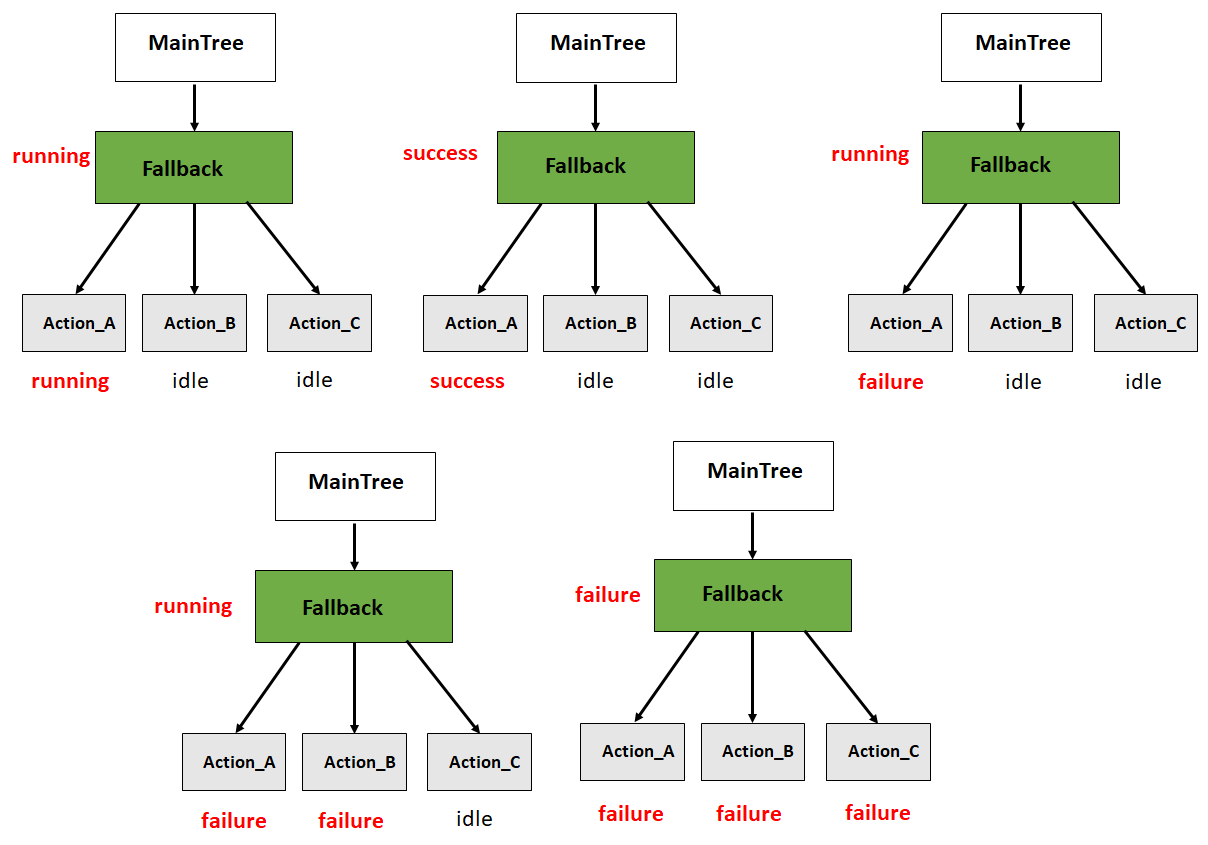

La sintaxis para describir este árbol es la siguiente:

In [ ]:
<root main_tree_to_execute="MainTree">
    <BehaviorTree ID="MainTree">
        <Fallback name="Fallback">
            <Action_A/>
            <Action_B/>
            <Action_C/>
        </Fallback>
    </BehaviorTree>
</root>

-**Pipeline Sequence**: similar al nodo sequence con la particularidad de que, cuando un nodo hijo devuelve un resultado success, se siguen ejecutando el resto de los nodos y vuelven a ejecutarse los anteriores. En el momento en que un nodo devuelve failure, se para la ejecución de todos los nodos y el nodo de control dará como salida failure. Sólo cuando el último nodo devuelve success se obtiene como salida del nodo de control success.

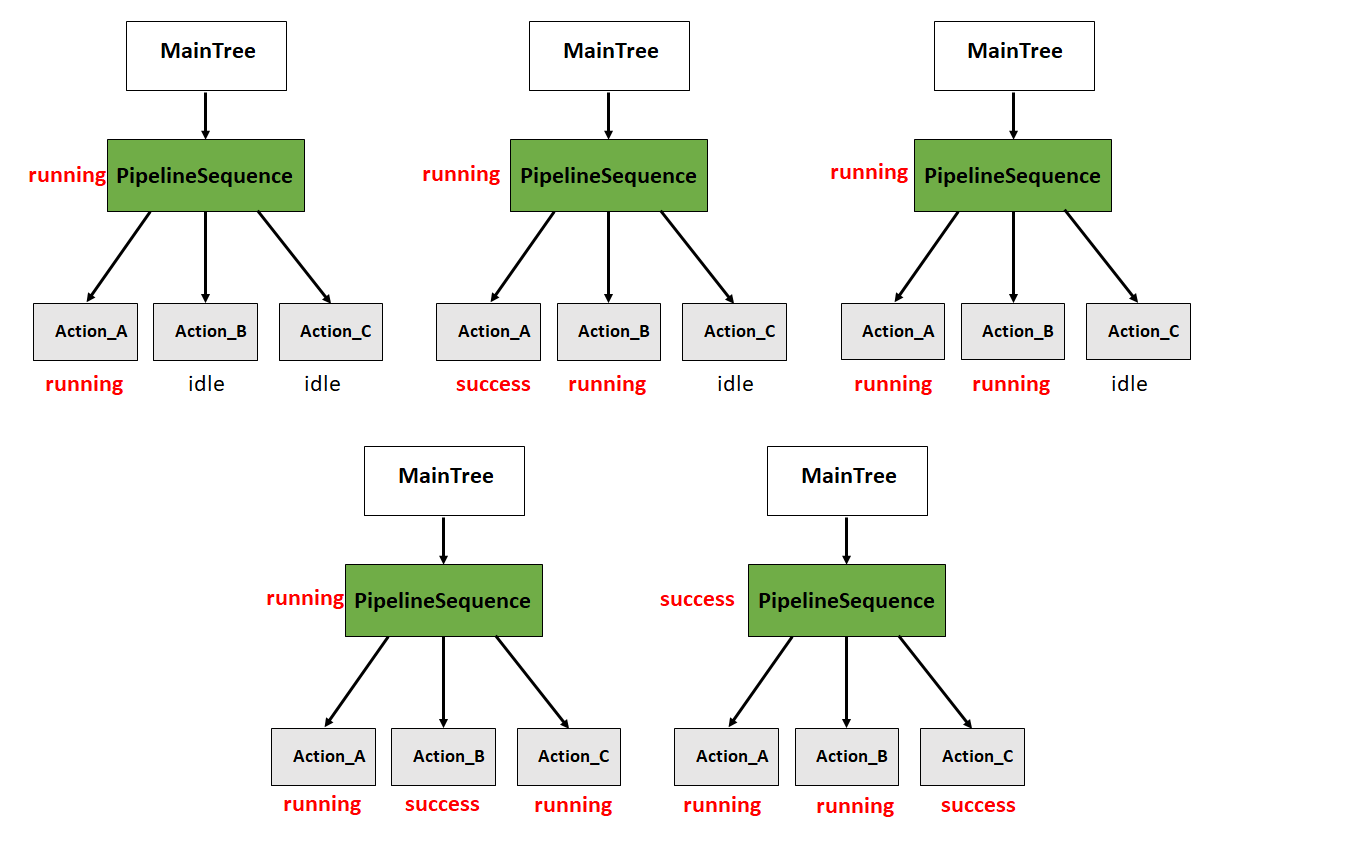

La descripción de este tipo de nodos toma la siguiente forma:

In [ ]:
<root main_tree_to_execute="MainTree">
    <BehaviorTree ID="MainTree">
        <PipelineSequence name="PipelineSequence">
            <Action_A/>
            <Action_B/>
            <Action_C/>
        </PipelineSequence>
    </BehaviorTree>
</root>

- **Recovery**: sólo posee dos nodos hijos. El nodo de control devuelve success si el primer nodo hijo devuelve success. En el caso de que el primer nodo falle se siguen ejecutando un nodo detrás de otro hasta que el primer nodo devuelva success o se haya ejecutado un número determinado de veces. Normalmente la activación del segundo nodo conlleva alguna acción que permite que el primer nodo se ejecute con éxito.

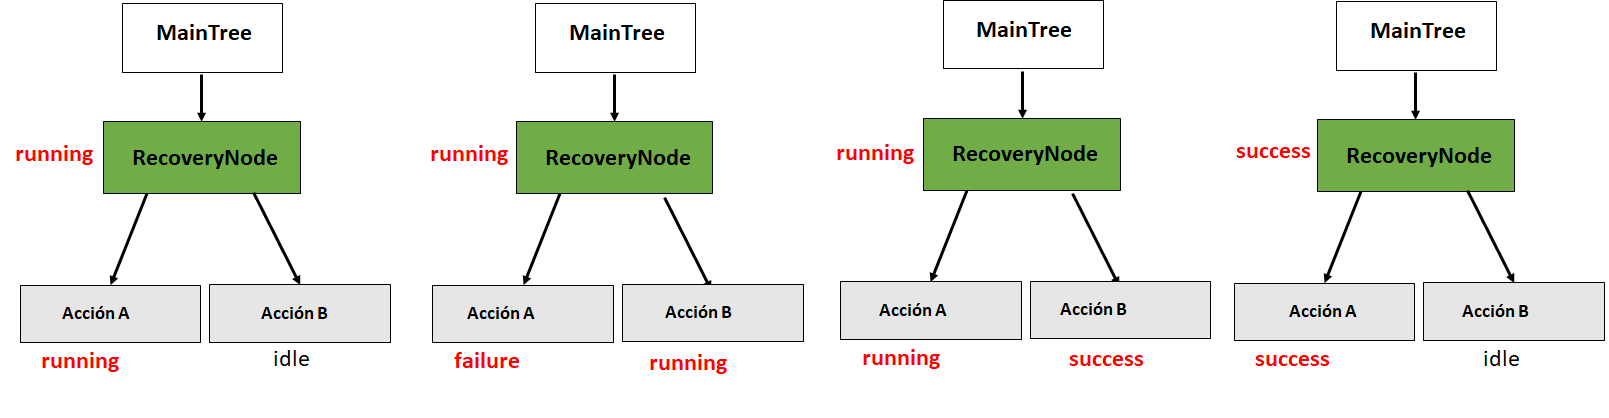

La descripción tendrá la siguiente forma:

In [ ]:
<root main_tree_to_execute="MainTree">
    <BehaviorTree ID="MainTree">
        <RecoveryNode number_of_retries="1" name="RecoveryNode">
            <Accion A/>
            <Accion B/>
        </RecoveryNode>
    </BehaviorTree>
</root>

- **Round Robin**: los nodos hijos se van ejecutando indefinidamente, uno tras otro, hasta que todos los nodos fallen, momento en el cual devuelve failure. Mientras algún nodo hijo devuelva success el nodo de control devolverá success.

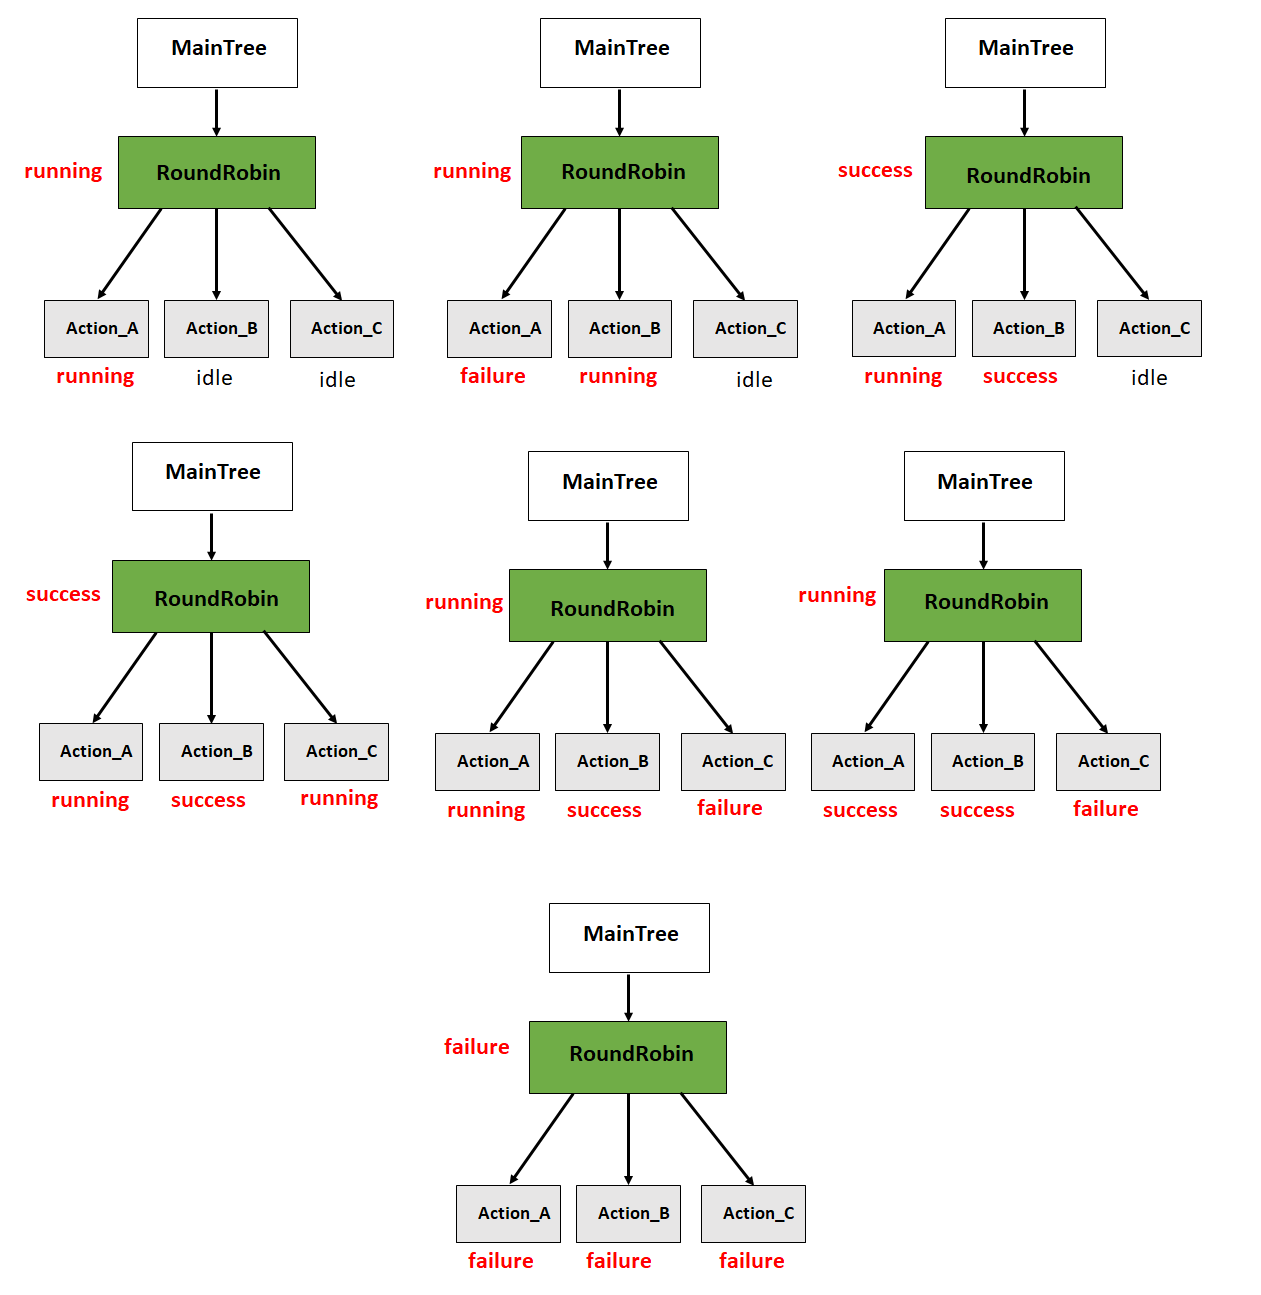

In [ ]:
<root main_tree_to_execute="MainTree">
    <BehaviorTree ID="MainTree">
        <RoundRobin name="RoundRobin">
            <Action_A/>
            <Action_B/>
            <Action_C/>
        </RoundRobin>
    </BehaviorTree>
</root>

# Nodos de acción en Navigation2

Los nodos de acción pueden tener tres estados de salida:

- **success**: si la ejecución ha sido exitosa

- **failure**: si la ejecunción ha fallado

- **running**: si se está ejecutando

El sistema de navegación Navigation2 utilizar los siguientes nodos de acción:

- **ComputePathToPose**: calcula la trayectoria al destino

- **FollowPath** : controla que el robot va siguiendo el camino calculado

- **Spin**: hace girar el robor

- **Wait**: detiene el robot

- **Backup**: guarda el estado del robot

- **ClearCostmapService**: limpia el mapa

# Decoradores

Sirven para configurar algún parámetro de las acciones a ejecutar. En el caso del paquete Navigation2, se utilizan los siguientes decoradores:

- **Distance Controller** - propaga el tick hacia los nodos hijos cada vez que el robot ha recorrido cierta distancia

- **Rate Controller** - controla la frecuencia del tick

- **Goal Updater** - Actualiza el destino de navegación

- **Single Trigger** - permite sólo un tick en cada uno de los nodos hijos y devuelve failure para los siguientes ticks

- **Speed Controller** - fija el tick de los nodos hijos a una frecuencia proporcional a la velocidad del robot.

# Nodos de condición

Chequean si se ha cumplido cierta condición.
En el caso del paquete Navigation2, la condición a chequear es si se ha actualizado el destino. Esta es la entrada al servidor de la acción nav_to_pose:

- **GoalUpdate**: comprueba si se ha actualizado el destino del robot.

# Árbol de comportamiento del sistema de Navegación

El fichero navigate_to_pose_w_replanning_and_recovery.xml describe el árbol de comportamiento que utiliza el paquete de navegación. Se trata de un árbol complejo que introduce mecanismos de recuperación (utilizando nodos de control tipo Recovery). La siguiente figura muestra el árbol completo:

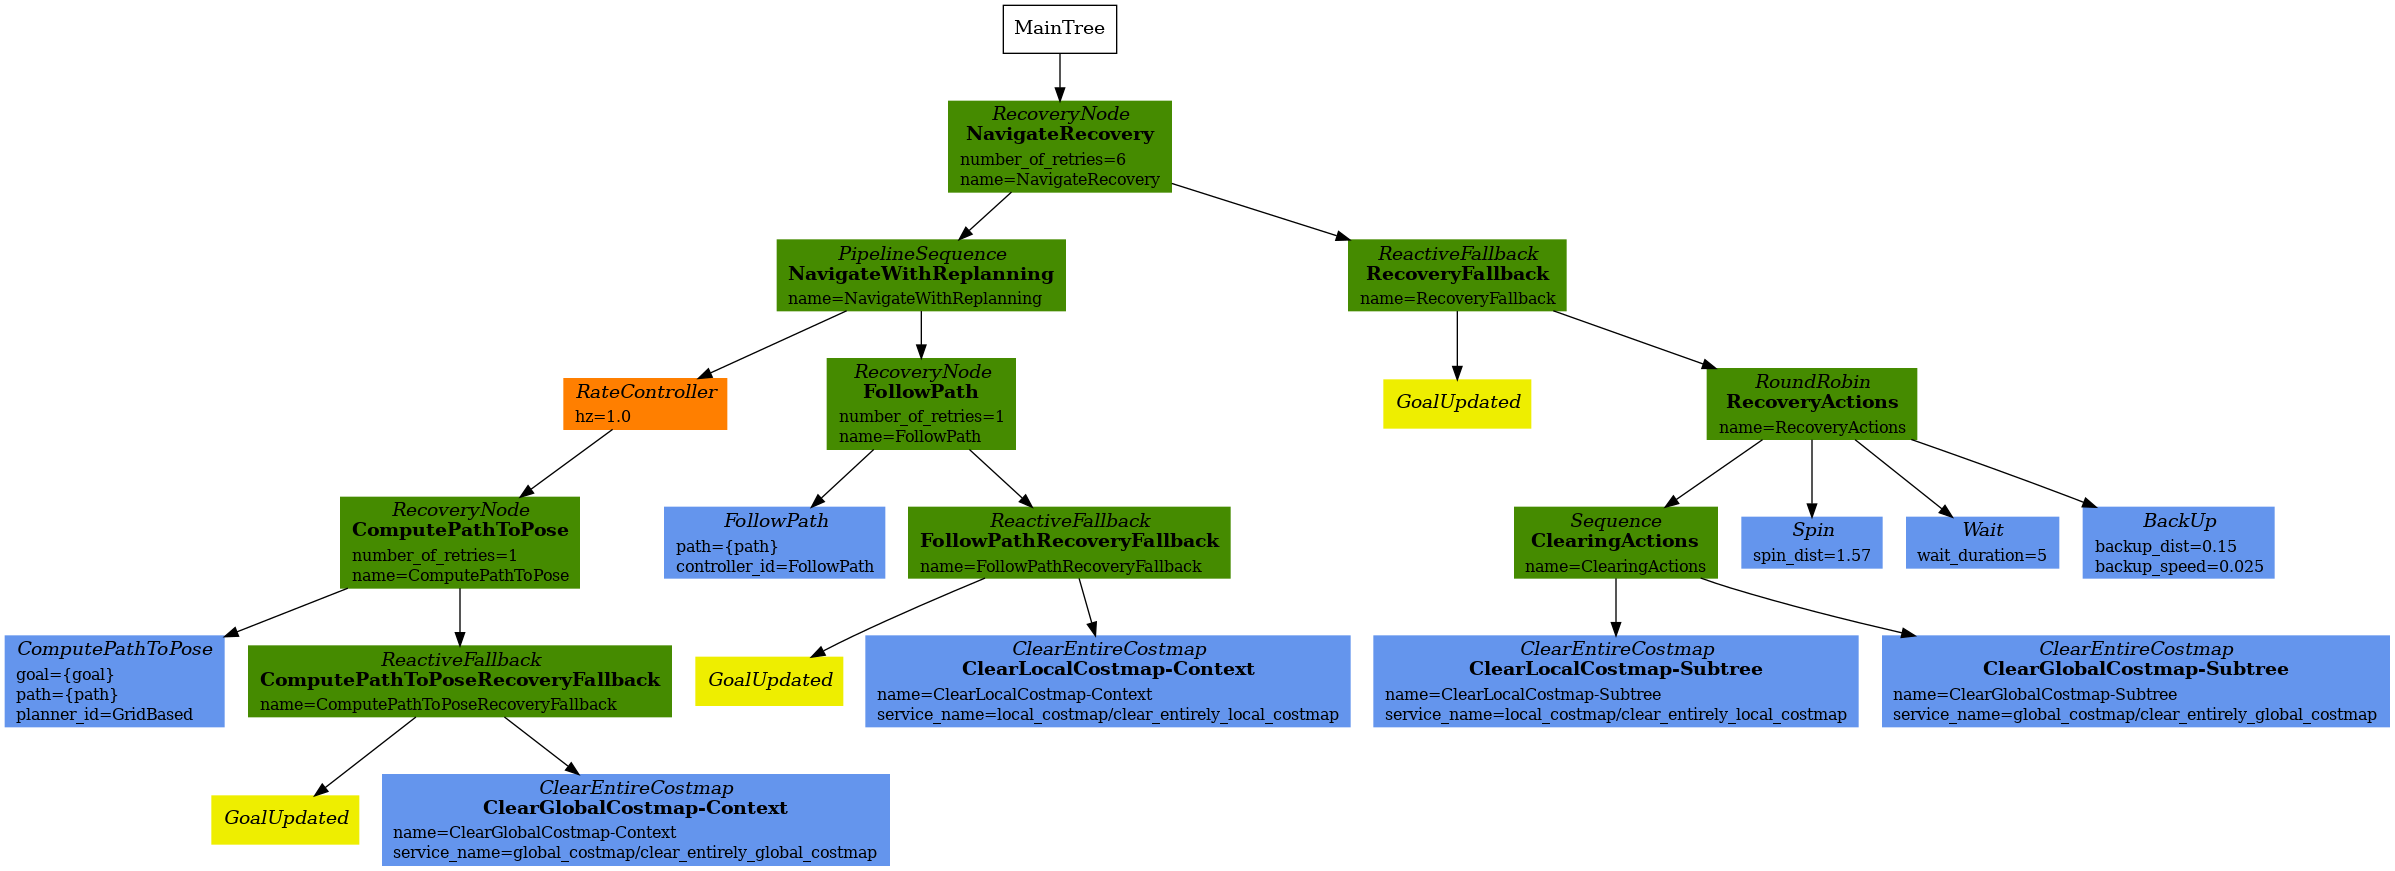

La parte izquierda muestra el sub-árbol de navegación, mientras que la parte derecha muestra el sub-árbol de recuperación (el que se ejecutará cuando el robot se quede atascado). En el grafo anterior se han pintado los nodos de control en verde, los nodos de acción en azul, los nodos de condición en amarillo y los decoradores en naranja.

El código completo de este árbol es el siguiente:

In [ ]:
<!--
  This Behavior Tree replans the global path periodically at 1 Hz and it also has
  recovery actions.
-->
<root main_tree_to_execute="MainTree">
  <BehaviorTree ID="MainTree">
    <RecoveryNode number_of_retries="6" name="NavigateRecovery">
      <PipelineSequence name="NavigateWithReplanning">
        <RateController hz="1.0">
          <RecoveryNode number_of_retries="1" name="ComputePathToPose">
            <ComputePathToPose goal="{goal}" path="{path}" planner_id="GridBased"/>
            <ClearEntireCostmap name="ClearGlobalCostmap-Context" service_name="global_costmap/clear_entirely_global_costmap"/>
          </RecoveryNode>
        </RateController>
        <RecoveryNode number_of_retries="1" name="FollowPath">
          <FollowPath path="{path}" controller_id="FollowPath"/>
          <ClearEntireCostmap name="ClearLocalCostmap-Context" service_name="local_costmap/clear_entirely_local_costmap"/>
        </RecoveryNode>
      </PipelineSequence>
      <ReactiveFallback name="RecoveryFallback">
        <GoalUpdated/>
        <SequenceStar name="RecoveryActions">
          <ClearEntireCostmap name="ClearLocalCostmap-Subtree" service_name="local_costmap/clear_entirely_local_costmap"/>
          <ClearEntireCostmap name="ClearGlobalCostmap-Subtree" service_name="global_costmap/clear_entirely_global_costmap"/>
          <Spin spin_dist="1.57"/>
          <Wait wait_duration="5"/>
        </SequenceStar>
      </ReactiveFallback>
    </RecoveryNode>
  </BehaviorTree>
</root>
